# Chapter 02. GMVP on industry sectors

- In this chpater, we are going to apply a global minimum variance portfolio(GMVP) on industry sectors.
- Rather than applying GMVP on individual stocks, this method performs portfolio optimization 2 times : firstly inside clusters and secondly between clusters.
- More details can be found in the academic paper <a href="https://lup.lub.lu.se/student-papers/search/publication/8931835"> __An alternative approach for solving the problem of close to singular covariance matrices in modern portfolio theory__ </a>.
- The portfolio performance of it will be used as a second benchmark for comparison

__Contents__

- [__Step 01. Loading stock data__](#Step-01.-Loading-stock-data)
- [__Step 02. Validation period performance__](#Step-02.-Validation-period-performance)
- [__Step 03. Test period performance__](#Step-03.-Test-period-performance)

---

## Step 01. Loading stock data

__1. Importing required libraries__

In [2]:
# for importing libraries again that is already imported, just in case that any change is made in libraries
%load_ext autoreload
%autoreload 2

# libraries for general work
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

# for computing portfolio performance
from portfolio_performance_function import *

# Disable printing all warnings on python 
import warnings
warnings.filterwarnings("ignore")

# libraries related with plotting
import seaborn as sns
import matplotlib.pyplot as plt

__2. Loading daily price of all stocks for indexing dates : `daily_price_df`__

In [3]:
# Loading
with open('./data/russel1000_daily_price_df.pickle', 'rb') as f:
    daily_price_df = pickle.load(f)
del daily_price_df.index.name

daily_price_df.head(3)

,MMM,ABT,ABMD,ACHC,ATVI,ADBE,AMD,AES,AMG,AFL,...,ZBRA,ZION,XEL,XRX,XLNX,YUM,BRK-B,HEI-A,LGF-A,JW-A
1999-11-01,26.186508,7.625059,10.2500,3.750,1.057096,17.013006,10.15625,22.383265,17.685398,5.895580,...,26.222221,44.172218,8.828288,59.627827,28.284966,4.807233,41.740002,1.899360,1.423901,12.179971
1999-11-02,26.430267,7.187653,10.3125,3.750,1.071191,16.888933,10.28125,22.780302,17.523146,6.068317,...,25.388889,45.481014,8.853581,57.188522,28.801279,4.733161,42.820000,1.891793,1.385417,12.134530
1999-11-03,26.325787,6.963037,10.2500,3.875,1.089984,17.075039,10.65625,22.209560,17.604273,6.150932,...,24.944445,44.920109,8.727110,57.324043,30.417568,4.651680,43.060001,1.755583,1.539352,11.725501


__3. Creating a list of all tickers : `all_tickers_list`__

In [4]:
all_tickers_list = list(daily_price_df.columns)

__4. Loading a grouped daily return data for validation : `daily_return_df_list_validation`__

In [5]:
# Loading
with open('./data/russel1000_daily_return_df_validation.pickle', 'rb') as f:
    daily_return_df_list_validation = pickle.load(f)
    
print(f"Total number of portfolio rebalancing  : {len(daily_return_df_list_validation)}" )
print(f"shape of dataframe : {daily_return_df_list_validation[0].shape}" )

Total number of portfolio rebalancing  : 47
shape of dataframe : (252, 590)


In [6]:
print("---validation---")
print(f"first day date: {daily_return_df_list_validation[1].index[-60].date()}")
print(f"last day date: {daily_return_df_list_validation[-1].index[-1].date()}")

---validation---
first day date: 2000-10-31
last day date: 2011-10-20


In [7]:
# investment dates
investment_dates_validation = daily_price_df.loc['2000-10-31':'2011-10-20',:].index
len(investment_dates_validation)

2760

__5. Loading a grouped daily return data for test : `daily_return_df_list_test`__

In [8]:
# Loading
with open('./data/russel1000_daily_return_df_test.pickle', 'rb') as f:
    daily_return_df_list_test = pickle.load(f)
    
print(f"Total number of portfolio rebalancing : {len(daily_return_df_list_test)}" )
print(f"shape of dataframe : {daily_return_df_list_test[0].shape}" )

Total number of portfolio rebalancing : 31
shape of dataframe : (252, 590)


In [9]:
print("---test---")
print(f"first day date: {daily_return_df_list_test[1].index[-60].date()}")
print(f"last day date: {daily_return_df_list_test[-1].index[-1].date()}")

---test---
first day date: 2012-10-04
last day date: 2019-11-29


In [10]:
# investment dates
investment_dates_test = daily_price_df.loc['2012-10-04':'2019-11-29',:].index
len(investment_dates_test)

1800

__6. loading the dictinary file containing sector information of each company__

In [11]:
# Loading
with open('./data/russel1000_sector_dict.pickle', 'rb') as f:
    sector_info_dict = pickle.load(f)

In [12]:
industry_list = list(sector_info_dict.keys())
industry_list

['Industrials',
 'Healthcare',
 'Communication Services',
 'Technology',
 'Utilities',
 'Financial Services',
 'Basic Materials',
 'Real Estate',
 'Consumer Defensive',
 'Consumer Cyclical',
 'Energy']

In [34]:
for industry in industry_list:
    print(f" {industry} : {len(sector_info_dict[industry])}")

 Industrials : 93
 Healthcare : 68
 Communication Services : 18
 Technology : 67
 Utilities : 31
 Financial Services : 92
 Basic Materials : 30
 Real Estate : 49
 Consumer Defensive : 37
 Consumer Cyclical : 73
 Energy : 32


---

## Step 02. Creating functions for portfolio optimization

- As the clustering approach to GMVP performs portfolio optimization twice, we are going to build two functions
    1. __within cluster optimization__ : `GMVP_within_sector`
    2. __between clusters optimization__: `GMVP_between_sectors`

__1. `GMVP_within_sector` : This function is used inside another function, `GMVP_between_sectors`.__
- __Input :__  
    1. daily_return_df_list_validation
- __Output :__  
    1. daily_sector_returns    
    2. within_sector_weights   

In [13]:
def GMVP_within_sector(data_period, index, sector):
    
    if data_period == 'validation':
        daily_return_df_list = daily_return_df_list_validation
    elif data_period == 'test':
        daily_return_df_list = daily_return_df_list_test
    
    # slice the data needed
    sliced_data_df = daily_return_df_list[index].loc[:, sector_info_dict[sector]]
    
    # get the covariance matrix and inverse matrix of covariance matrix respectively
    cov_mat = sliced_data_df.cov()
    cov_mat_values = cov_mat.values
    inv_cov_mat = np.linalg.pinv(cov_mat_values) # Use pseudo-inverse incase matrix is singular / ill-conditioned

    # get the portfolio weights of GMVP
    ones = np.ones(len(inv_cov_mat))
    inv_dot_ones = np.dot(inv_cov_mat, ones)
    within_sector_weights = inv_dot_ones/ np.dot(inv_dot_ones, ones)
    
    # using the portfolio weights, get the daily portfolio returns
    daily_weighted_returns = (sliced_data_df * within_sector_weights)
    daily_sector_returns = daily_weighted_returns.sum(axis=1)
    
    return daily_sector_returns, within_sector_weights

__2. `GMVP_between_sectors`__
- __Input :__  
    1. daily_return_df_list
- __Output :__  
    1. daily_portfolio_returns   
    2. in_sample_stdev  
    3. out_of_sample_stdev  
    4. individual_stock_weights  
    5. sector_weights  
    6. sector_returns_df_list

In [14]:
def GMVP_between_sectors(data_period):
    rebalancing_period = 60

    # creating lists for storing outcomes
    out_of_sample_daily_portfolio_returns_list = []
    in_sample_stdev_list = []
    out_of_sample_stdev_list = []
    daily_sector_returns_list = []
    portfolio_weights_list = []
    between_sector_weights_list = []

    if data_period == 'validation':
        daily_return_df_list = daily_return_df_list_validation
    elif data_period == 'test':
        daily_return_df_list = daily_return_df_list_test

    # ----------------------------------------------- #
    # portfolio optimization for each daily_return_df #
    # ----------------------------------------------- #
    for index_no, daily_return_df in enumerate(tqdm(daily_return_df_list)):
        
        daily_sector_returns_dict = {}
        within_sector_weights_dict = {}

        # --------------------------- #
        # within cluster optimization #
        # --------------------------- #
        for industry in industry_list:
            daily_sector_returns, within_sector_weights = GMVP_within_sector(data_period, index_no, industry)
            daily_sector_returns_dict[industry] = daily_sector_returns
            within_sector_weights_dict[industry] = within_sector_weights

        # ----------------------------- #
        # between clusters optimization #
        # ----------------------------- #
        sector_daily_returns_df = pd.DataFrame.from_dict(daily_sector_returns_dict)
        daily_sector_returns_list.append(sector_daily_returns_df)

        cov_mat = sector_daily_returns_df.cov()
        cov_mat_values = cov_mat.values
        inv_cov_mat = np.linalg.pinv(cov_mat_values) # Use pseudo-inverse incase matrix is singular / ill-conditioned

        # get the weights of each sector(between_sector_weights)
        ones = np.ones(len(inv_cov_mat))
        inv_dot_ones = np.dot(inv_cov_mat, ones)
        between_sector_weights = inv_dot_ones/ np.dot(inv_dot_ones, ones)
        between_sector_weights_df = pd.DataFrame(between_sector_weights, index = industry_list, columns = ['sector_weight'])

        temp_portfolio_weights_list = []

        for industry in industry_list:
            stock_weights_within_sector =  between_sector_weights_df.loc[industry,'sector_weight'] * within_sector_weights_dict[industry]
            stock_weights_within_sector_df = pd.DataFrame(stock_weights_within_sector, index = sector_info_dict[industry], columns = ['weight'])
            temp_portfolio_weights_list.append(stock_weights_within_sector_df)

        portfolio_weights = pd.concat(temp_portfolio_weights_list)
        portfolio_weights_list.append(portfolio_weights)

        # in_sample portfolio_variance
        in_sample_variance = np.dot(between_sector_weights, np.dot(cov_mat_values, between_sector_weights))
        in_sample_stdev = np.sqrt(in_sample_variance)

        # ---------------------------------------------------------- #
        # Calculating daily return based on GMV optimization results #
        # ---------------------------------------------------------- #
        # we should use 'index+1' ; we optimize portfolio at the time point 'index' and see how it goes for the time period from 'index' to 'index+1'

        if (index_no+1) < len(daily_return_df_list):

            # appending
            between_sector_weights_list.append(between_sector_weights_df)
            in_sample_stdev_list.append(in_sample_stdev)

            # for calculating the future returns
            future_daily_returns_df = daily_return_df_list[index_no+1]
            future_sector_returns_dict = {}

            for industry in industry_list:
                weighted_returns = (future_daily_returns_df.loc[:,sector_info_dict[industry]] * between_sector_weights_df.loc[industry,'sector_weight'] * within_sector_weights_dict[industry])
                sector_returns = weighted_returns.sum(axis=1)
                future_sector_returns_dict[industry] = sector_returns

            temp_out_of_sample_portfolio_returns = pd.DataFrame.from_dict(future_sector_returns_dict)
            out_of_sample_portfolio_returns = temp_out_of_sample_portfolio_returns.sum(axis=1)[-rebalancing_period:]

            # out of 180 days, the first 160 days are overlappign with each other
            out_of_sample_stdev_list.append(out_of_sample_portfolio_returns.std())
            out_of_sample_daily_portfolio_returns_list.extend(out_of_sample_portfolio_returns)

    out_of_sample_daily_portfolio_returns_array = np.array(out_of_sample_daily_portfolio_returns_list)

    result_dict = {'daily_portfolio_returns' : out_of_sample_daily_portfolio_returns_array,
                   'in_sample_stdev' : pd.Series(in_sample_stdev_list), 
                   'out_of_sample_stdev' : pd.Series(out_of_sample_stdev_list),
                   'individual_stock_weights' : portfolio_weights_list,
                   'sector_weights' : between_sector_weights_list,
                   'sector_return_df_list' : daily_sector_returns_list,}

    return result_dict

---

## Step 03. Validation period performance

__1. Portfolio optimization for validation period__

In [15]:
result_dict_validation = GMVP_between_sectors('validation')

In [16]:
result_dict_validation['out_of_sample_stdev'].mean()

0.005971469986548483

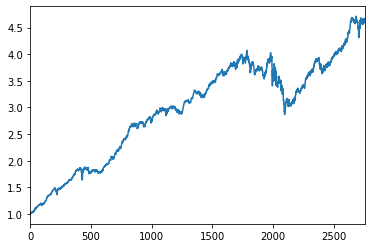

In [17]:
pd.Series(result_dict_validation['daily_portfolio_returns']+1).cumprod().plot()

In [18]:
result_dict_validation['daily_portfolio_returns'].std()

0.006959977804612992

In [19]:
print(f"sharpe_ratio : {get_single_sharpe_ratio(result_dict_validation['daily_portfolio_returns']):.5f}")
print(f"sortino_ratio : {get_single_sortino_ratio(result_dict_validation['daily_portfolio_returns']):.5f}")

sharpe_ratio : 0.08348
sortino_ratio : 0.10831


In [20]:
# # Saving
# with open('result/2. GMVP_industries_validation.pickle', 'wb') as f: # 
#     pickle.dump(result_dict_validation, f, pickle.HIGHEST_PROTOCOL)

In [21]:
# Loading
with open('result/2. GMVP_industries_validation.pickle', 'rb') as f:
    result_dict_validation = pickle.load(f)

__2. Performance check-up__

In [22]:
# estimated_std
print(f"in-sample stdev : {pd.Series(result_dict_validation['in_sample_stdev']).mean():.5f}")
# realized_std
print(f"out-of-sample stdev : {pd.Series(result_dict_validation['out_of_sample_stdev']).mean():.5f}")
print('------------------------------')
# downside_std
print(f"downside_std : {get_single_downside_stdev(result_dict_validation['daily_portfolio_returns']):.5f}")
# MDD
print(f"MDD : {get_maximum_drawdown(result_dict_validation['daily_portfolio_returns'])*100:.2f}%")
# CVaR_95
print(f"CVaR_95 : {get_cvar_95(result_dict_validation['daily_portfolio_returns'])*100:.2f}%")

in-sample stdev : 0.00309
out-of-sample stdev : 0.00597
------------------------------
downside_std : 0.00537
MDD : -29.58%
CVaR_95 : -1.18%


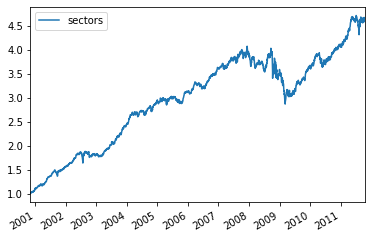

In [23]:
# cumulative wealth
(pd.DataFrame(result_dict_validation['daily_portfolio_returns'], index=investment_dates_validation , columns=['sectors'])+1).cumprod().plot();

__Portfolio weights__

In [24]:
time_index = 0

print(f"time index : {time_index}")
weight_df = result_dict_validation['individual_stock_weights'][time_index]
print(f"maximum weight: {weight_df.index[-1]}, {weight_df.iloc[0,0]*100:.2f}%")
print(f"minimum weight: {weight_df.index[0]}, {weight_df.iloc[-1,0]*100:.2f}%")

time index : 0
maximum weight: CHK, 0.22%
minimum weight: MMM, 0.03%


__Difference between `in-sample stdev` and `out-of-sample stdev`__

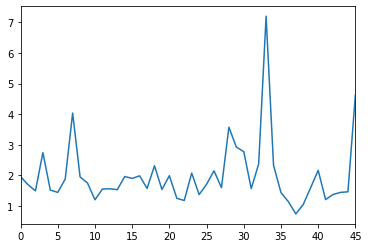

In [25]:
(pd.Series(result_dict_validation['out_of_sample_stdev'])/pd.Series(result_dict_validation['in_sample_stdev'])).plot()

---

## Step 04. Test period performance

__1. Portfolio optimization for test period__

In [26]:
result_dict_test = GMVP_between_sectors('test')

In [27]:
# # Saving
# with open('result/2. GMVP_industries_test.pickle', 'wb') as f: # 
#     pickle.dump(result_dict_test, f, pickle.HIGHEST_PROTOCOL)

In [28]:
# Loading
with open('result/2. GMVP_industries_test.pickle', 'rb') as f:
    result_dict_test = pickle.load(f)

__2. Performance check-up__

In [33]:
# sharpe_raito
print(f"sharpe_ratio : {get_single_sharpe_ratio(result_dict_test['daily_portfolio_returns']):.5f}")
print(f"sortino_ratio : {get_single_sortino_ratio(result_dict_test['daily_portfolio_returns']):.5f}")
print('------------------------------')
# estimated_std
print(f"in-sample stdev : {pd.Series(result_dict_test['in_sample_stdev']).mean():.5f}")
# realized_std
print(f"out-of-sample stdev : {pd.Series(result_dict_test['out_of_sample_stdev']).mean():.5f}")
# real_stdev
print(f"real_stdev : {result_dict_test['daily_portfolio_returns'].std():.5f}")
print('------------------------------')
# downside_std
print(f"downside_std : {get_single_downside_stdev(result_dict_test['daily_portfolio_returns']):.5f}")
# MDD
print(f"MDD : {get_maximum_drawdown(result_dict_test['daily_portfolio_returns'])*100:.2f}%")
# CVaR_95
print(f"CVaR_95 : {get_cvar_95(result_dict_test['daily_portfolio_returns'])*100:.2f}%")

sharpe_ratio : 0.11405
sortino_ratio : 0.15768
------------------------------
in-sample stdev : 0.00290
out-of-sample stdev : 0.00532
real_stdev : 0.00554
------------------------------
downside_std : 0.00401
MDD : -9.32%
CVaR_95 : -0.97%


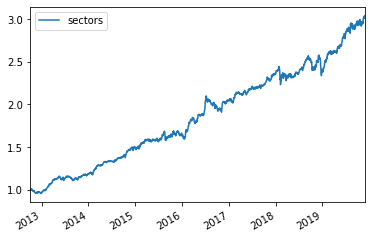

In [30]:
# cumulative wealth
(pd.DataFrame(result_dict_test['daily_portfolio_returns'], index=investment_dates_test , columns=['sectors'])+1).cumprod().plot();

__Portfolio weights__

In [41]:
time_index = 0

print(f"time index : {time_index}")
weight_df = result_dict_test['individual_stock_weights'][time_index]
print(f"maximum weight: {weight_df.index[-1]}, {weight_df.iloc[0,0]*100:.2f}%")
print(f"minimum weight: {weight_df.index[0]}, {weight_df.iloc[-1,0]*100:.2f}%")

time index : 0
maximum weight: CHK, 3.26%
minimum weight: MMM, -0.08%


__Difference between `in-sample stdev` and `out-of-sample stdev`__

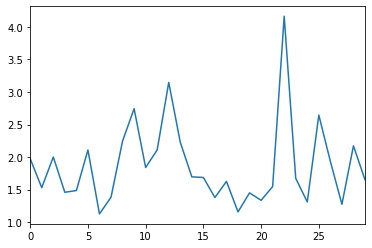

In [42]:
(pd.Series(result_dict_test['out_of_sample_stdev'])/pd.Series(result_dict_test['in_sample_stdev'])).plot()

---